### <font color='salmon'>  Corporación Favorita Grocery Sales Forecasting


### <font color='salmon'>Importing all the libraries that we will need</font>

In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import gc

import seaborn as sns
sns.set(style = 'whitegrid', color_codes = True)
%matplotlib inline

#For statistical tests
import scipy.stats as st

#For formula notation (similar to R)
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import operator

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### <font color='salmon'>Read the Data</font>

In [2]:
df_train = pd.read_csv("../input/corporitasampled-train-data/train_rd.csv")

In [3]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,14269441,2013-11-20,40,502224,1.0,NaN
1,78096733,2016-05-03,24,472526,2.0,False
2,76462175,2016-04-16,28,1339879,4.0,False
3,78232274,2016-05-04,46,1501547,10.0,True
4,108042332,2017-03-03,37,1038946,5.0,False


In [4]:
print("we have taken ",len(df_train), "rows")

we have taken  12549704 rows


In [5]:
Input_Path = '../input/favorita-grocery-sales-forecasting/'

In [6]:
test  = pd.read_csv("../input/favorita-grocery-sales-forecasting/test.csv")
testg  = pd.read_csv("../input/favorita-grocery-sales-forecasting/test.csv")
store = pd.read_csv("../input/favorita-grocery-sales-forecasting/stores.csv")
holiday = pd.read_csv("../input/favorita-grocery-sales-forecasting/holidays_events.csv")
item = pd.read_csv("../input/favorita-grocery-sales-forecasting/items.csv")
oil = pd.read_csv("../input/favorita-grocery-sales-forecasting/oil.csv")
trans = pd.read_csv("../input/favorita-grocery-sales-forecasting/transactions.csv")

### <font color='salmon'>Getting familiar with the data</font>

### <font color='salmon'>train data</font>

* Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.
* The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).
* Negative values of unit_sales represent returns of that particular item.
* The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.
* Approximately 16% of the onpromotion values in this file are NaN.

In [7]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,14269441,2013-11-20,40,502224,1.0,NaN
1,78096733,2016-05-03,24,472526,2.0,False
2,76462175,2016-04-16,28,1339879,4.0,False
3,78232274,2016-05-04,46,1501547,10.0,True
4,108042332,2017-03-03,37,1038946,5.0,False


### <font color='salmon'>Items data</font>

* Item metadata, including family, class, and perishable.
* NOTE: Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0

In [8]:
item.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [9]:
print("There are",len(item['family'].unique()),"families of products or items")

There are 33 families of products or items


### <font color='salmon'>Oil data</font>

Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [10]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


### <font color='salmon'>Transaction data</font>
* The count of sales transactions for each date, store_nbr combination. 
* Only included for the training data timeframe.

In [11]:
trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### <font color='salmon'>Holiday data</font>

* Holidays and Events, with metadata
* A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. 
A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

In [12]:
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### <font color='salmon'>Store data</font>
* Store metadata, including city, state, type, and cluster.
* cluster is a grouping of similar stores.

In [13]:
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
print("There are",len(store['type'].unique()),"type of stores")

There are 5 type of stores


In [15]:
print("Stores are in ",len(store['city'].unique()),"cities in ", len(store['state'].unique()),"states")

Stores are in  22 cities in  16 states


### <font color='salmon'>Test data</font>

In [16]:
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


### <font color='salmon'>Join Data</font>

* Join stores and items data to Trian data with respect to Store number and Item number
* Join holiday and oil data to Train with respect to Date

In [17]:
train = pd.merge(df_train, store, on= "store_nbr")
train = pd.merge(train, item, on= "item_nbr")
train = pd.merge(train, holiday, on="date")
train = pd.merge(train, oil, on ="date")

In [18]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type_x,cluster,family,class,perishable,type_y,locale,locale_name,description,transferred,dcoilwtico
0,53608765,2015-08-10,40,502224,1.0,False,Machala,El Oro,C,3,GROCERY I,1062,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94
1,53603519,2015-08-10,37,502224,1.0,False,Cuenca,Azuay,D,2,GROCERY I,1062,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94
2,53624684,2015-08-10,49,502224,1.0,False,Quito,Pichincha,A,11,GROCERY I,1062,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94
3,53608748,2015-08-10,40,464336,8.0,False,Machala,El Oro,C,3,GROCERY I,1040,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94
4,53575694,2015-08-10,17,1176559,1.0,False,Quito,Pichincha,C,12,GROCERY I,1026,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94


Join Train and item data

In [19]:
train_items = pd.merge(df_train, item, how='inner')
train_items1 = pd.merge(df_train, item, how='inner')
train_items2 = pd.merge(df_train, item, how='inner')

In [20]:
train_items.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
0,14269441,2013-11-20,40,502224,1.0,NaN,GROCERY I,1062,0
1,23183502,2014-05-01,45,502224,6.0,False,GROCERY I,1062,0
2,83555679,2016-06-29,48,502224,1.0,False,GROCERY I,1062,0
3,33349722,2014-10-19,5,502224,2.0,True,GROCERY I,1062,0
4,21430616,2014-03-28,35,502224,1.0,NaN,GROCERY I,1062,0


### <font color='salmon'> Data Pre Processing</font>

### <font color='salmon'> Checking for missing Data</font>

In [21]:
oil_nan = (oil.isnull().sum() / oil.shape[0]) * 100
oil_nan

date          0.000000
dcoilwtico    3.530378
dtype: float64

Only 3.5% missing data on oil price

In [22]:
store_nan = (store.isnull().sum() / store.shape[0]) * 100
store_nan

store_nbr    0.0
city         0.0
state        0.0
type         0.0
cluster      0.0
dtype: float64

No missing store data

In [23]:
item_nan = (item.isnull().sum() / item.shape[0]) * 100
item_nan

item_nbr      0.0
family        0.0
class         0.0
perishable    0.0
dtype: float64

No missing item data

In [24]:
df_train_nan = (df_train.isnull().sum() / df_train.shape[0]) * 100
df_train_nan

id              0.000000
date            0.000000
store_nbr       0.000000
item_nbr        0.000000
unit_sales      0.000000
onpromotion    17.276232
dtype: float64

17.3% missing data on onpromotion

On promotion NAN values are UNKNOWN - if item is on promotion 

So replacing Nan of "on promotion" with 2 to indicate the items have unknown status on promotion

In [25]:
train['onpromotion'] = train['onpromotion'].fillna(2)
train['onpromotion'] = train['onpromotion'].replace(True,1)
train['onpromotion'] = train['onpromotion'].replace(False,0)

In [26]:
(train['onpromotion'].unique())

array([0, 1, 2])

Unknown oil price - putting 0 for now

In [27]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(0)

In [28]:
train['Year']  = train['date'].apply(lambda x: int(str(x)[:4]))
train['Month'] = train['date'].apply(lambda x: int(str(x)[5:7]))
train['date']  = train['date'].apply(lambda x: (str(x)[8:]))


test['Year']  = test['date'].apply(lambda x: int(str(x)[:4]))
test['Month'] = test['date'].apply(lambda x: int(str(x)[5:7]))
test['date']  = test['date'].apply(lambda x: (str(x)[8:]))

train.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type_x,cluster,...,class,perishable,type_y,locale,locale_name,description,transferred,dcoilwtico,Year,Month
0,53608765,10,40,502224,1.0,0,Machala,El Oro,C,3,...,1062,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94,2015,8
1,53603519,10,37,502224,1.0,0,Cuenca,Azuay,D,2,...,1062,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94,2015,8
2,53624684,10,49,502224,1.0,0,Quito,Pichincha,A,11,...,1062,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94,2015,8
3,53608748,10,40,464336,8.0,0,Machala,El Oro,C,3,...,1040,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94,2015,8
4,53575694,10,17,1176559,1.0,0,Quito,Pichincha,C,12,...,1026,0,Holiday,National,Ecuador,Primer Grito de Independencia,False,44.94,2015,8


In [29]:
train_items1['date'] = pd.to_datetime(train_items1['date'], format='%Y-%m-%d')
train_items1['day_item_purchased'] = train_items1['date'].dt.day
train_items1['month_item_purchased'] =train_items1['date'].dt.month
train_items1['quarter_item_purchased'] = train_items1['date'].dt.quarter
train_items1['year_item_purchased'] = train_items1['date'].dt.year
train_items1.drop('date', axis=1, inplace=True)

train_items2['date'] = pd.to_datetime(train_items2['date'], format='%Y-%m-%d')
train_items2['day_item_purchased'] = train_items2['date'].dt.day
train_items2['month_item_purchased'] =train_items2['date'].dt.month
train_items2['quarter_item_purchased'] = train_items2['date'].dt.quarter
train_items2['year_item_purchased'] = train_items2['date'].dt.year
train_items2.drop('date', axis=1, inplace=True)

In [30]:
#train_items['Year']  = train_items['date'].apply(lambda x: int(str(x)[:4]))
#train_items['Month'] = train_items['date'].apply(lambda x: int(str(x)[5:7]))
#train_items['date']  = train_items['date'].apply(lambda x: (str(x)[8:]))

In [31]:
train_items1.loc[(train_items1.unit_sales<0),'unit_sales'] = 1 
train_items1['unit_sales'] =  train_items1['unit_sales'].apply(pd.np.log1p) 

train_items1['family'] = train_items1['family'].astype('category')
train_items1['onpromotion'] = train_items1['onpromotion'].astype('category')
train_items1['perishable'] = train_items1['perishable'].astype('category')
cat_columns = train_items1.select_dtypes(['category']).columns
train_items1[cat_columns] = train_items1[cat_columns].apply(lambda x: x.cat.codes)

train_items2.loc[(train_items2.unit_sales<0),'unit_sales'] = 1 
train_items2['unit_sales'] =  train_items2['unit_sales'].apply(pd.np.log1p) 

train_items2['family'] = train_items2['family'].astype('category')
train_items2['onpromotion'] = train_items2['onpromotion'].astype('category')
train_items2['perishable'] = train_items2['perishable'].astype('category')
cat_columns = train_items2.select_dtypes(['category']).columns
train_items2[cat_columns] = train_items2[cat_columns].apply(lambda x: x.cat.codes)

In [32]:
train_items1.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,day_item_purchased,month_item_purchased,quarter_item_purchased,year_item_purchased
0,14269441,40,502224,0.693147,-1,12,1062,0,20,11,4,2013
1,23183502,45,502224,1.945910,0,12,1062,0,1,5,2,2014
2,83555679,48,502224,0.693147,0,12,1062,0,29,6,2,2016
3,33349722,5,502224,1.098612,1,12,1062,0,19,10,4,2014
4,21430616,35,502224,0.693147,-1,12,1062,0,28,3,1,2014


### <font color='salmon'> EDA </font>

We have taken a sample of train data to plot the graphs - the entire data is taking too much time

In [33]:
strain = train.sample(frac=0.01,replace=True)

### <font color='salmon'> Plotting Sales with promotion </font>

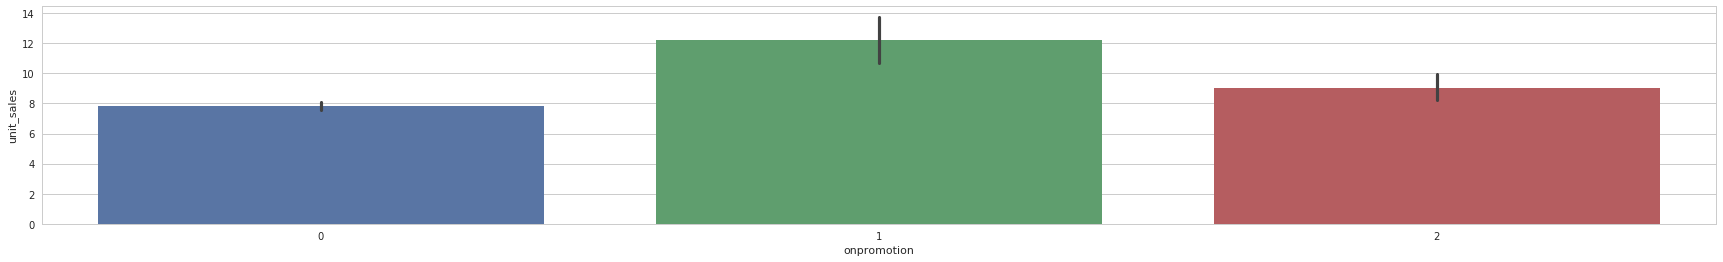

In [34]:
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.barplot(x='onpromotion', y='unit_sales', data=strain, ax=axis1)

### <font color='salmon'> Plotting Sales per Item Family </font>

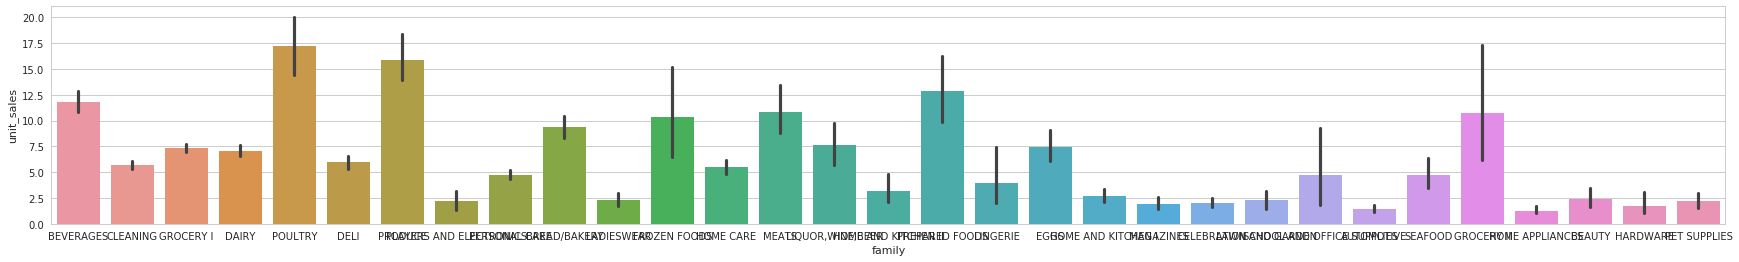

In [35]:
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.barplot(x='family', y='unit_sales', data=strain, ax=axis1)

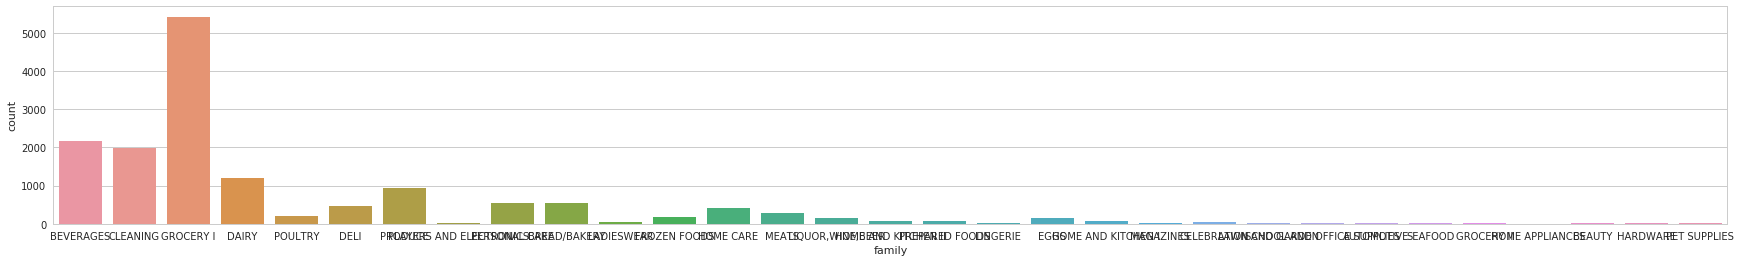

In [36]:
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x=strain['family'], data=strain, ax=axis1)

### <font color='salmon'> Plotting Sales per Store Type </font>

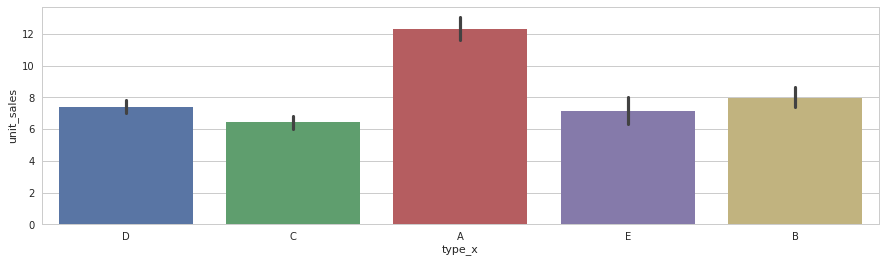

In [37]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='type_x', y='unit_sales', data=strain, ax=axis1)

Store type "A" is highest selling

### <font color='salmon'> Plotting Stores in Cities and states </font>

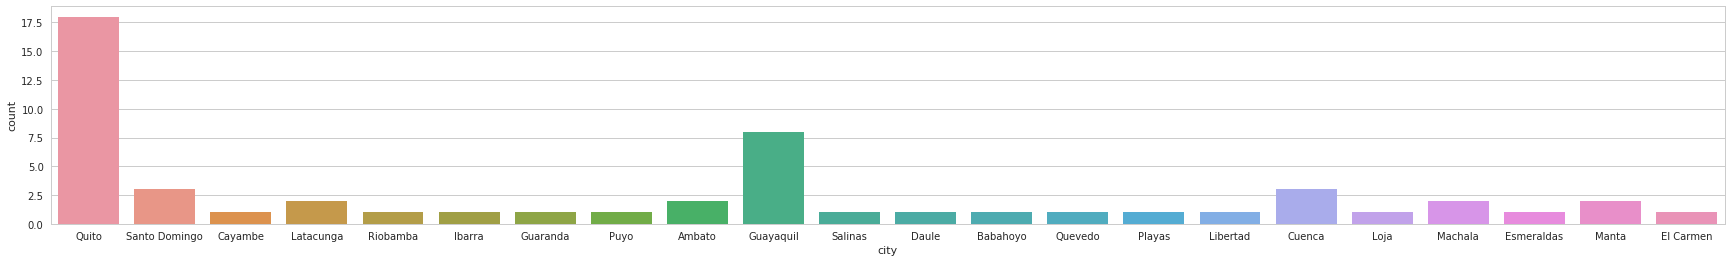

In [38]:
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x=store['city'], data=store, ax=axis1)

Quito and Guayaquil have the most number of stores

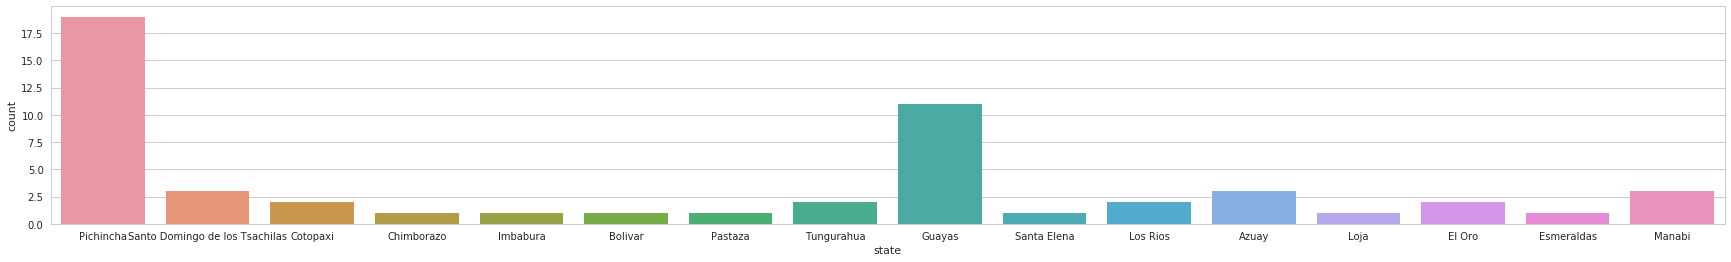

In [39]:
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x=store['state'], data=store, ax=axis1)

Pichincha and Guayas have highest number of stores

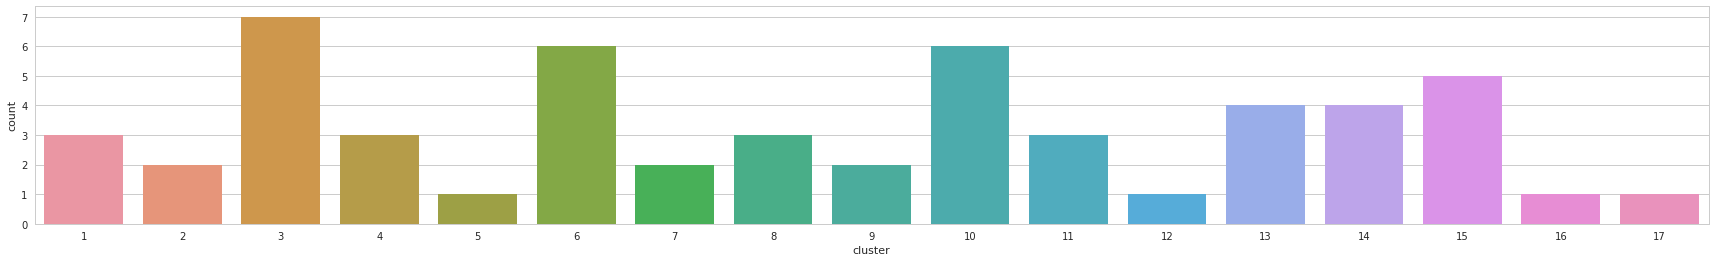

In [40]:
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x='cluster', data=store, ax=axis1)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


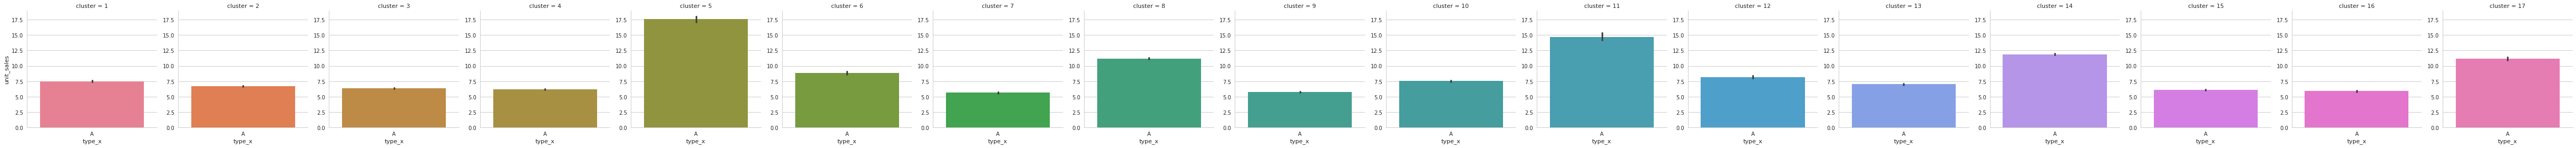

In [41]:
g = sns.FacetGrid(train, col='cluster', hue='cluster', size=4)
g.map(sns.barplot, 'type_x', 'unit_sales');

#### Plotting Oil Price

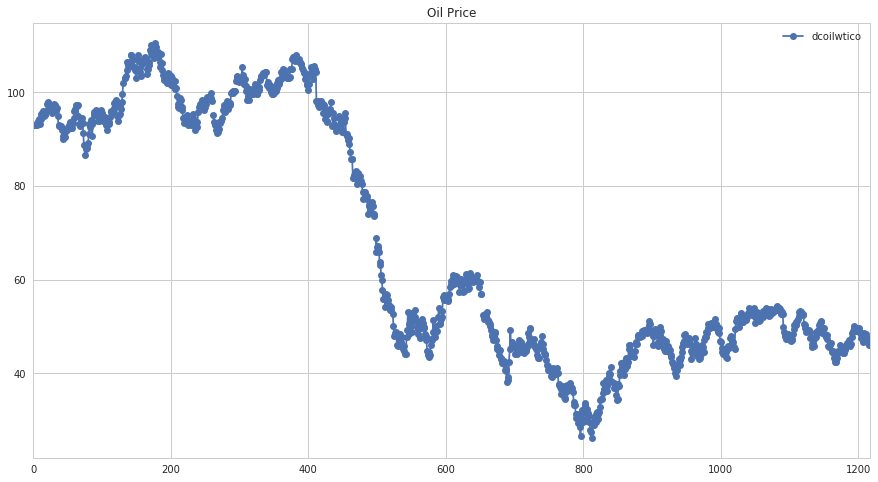

In [42]:
fig, (axis1) = plt.subplots(1,1,sharex=True,figsize=(15,8))

ax1 = oil.plot(legend=True,ax=axis1,marker='o',title="Oil Price")


### Plotting Sales with date

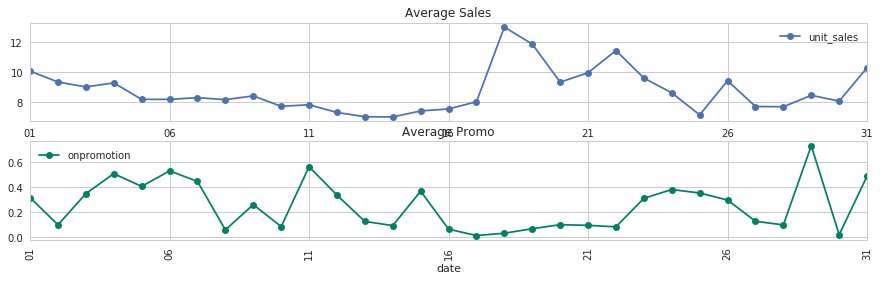

In [43]:
average_sales = train.groupby('date')["unit_sales"].mean()
average_promo = train.groupby('date')["onpromotion"].mean()

fig, (axis1, axis2) = plt.subplots(2,1,figsize=(15,4))

ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax2 = average_promo.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Average Promo")

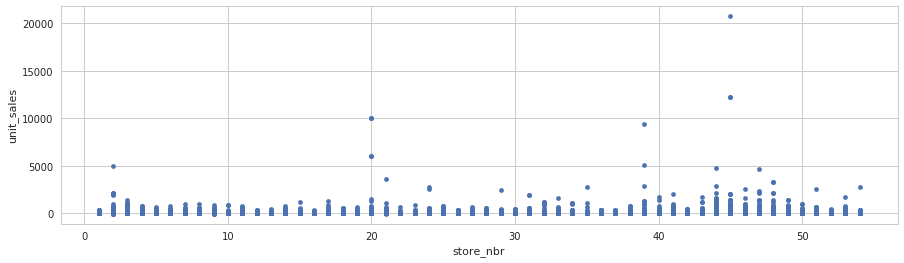

In [44]:
train.plot(kind='scatter',x='store_nbr',y='unit_sales',figsize=(15,4))

Store number 44 / 45 - maximum sales

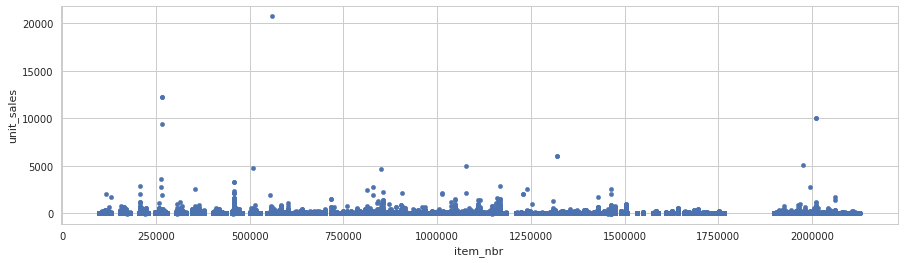

In [45]:
train.plot(kind='scatter',x='item_nbr',y='unit_sales',figsize=(15,4))

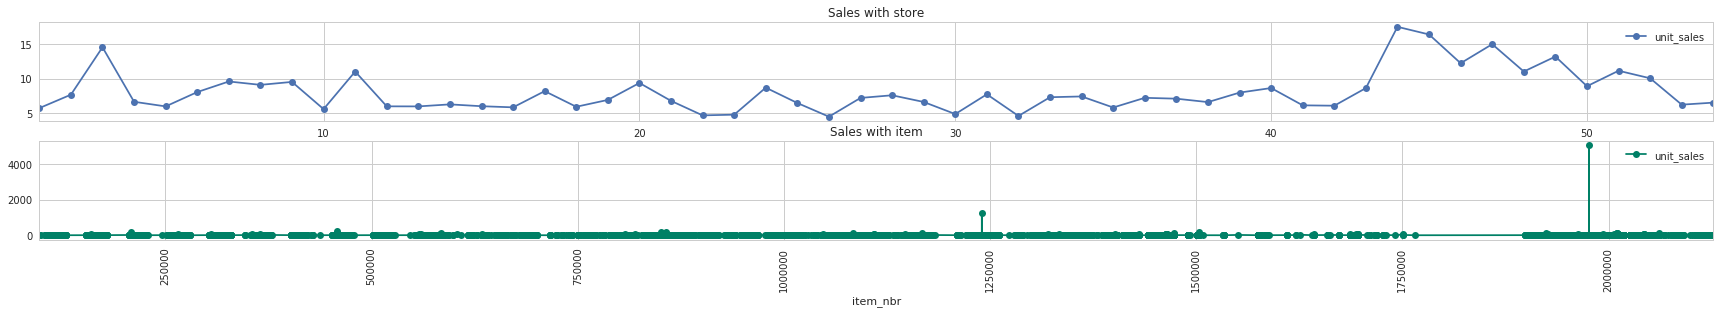

In [46]:
store_number = train.groupby('store_nbr')["unit_sales"].mean()
item_number = train.groupby('item_nbr')["unit_sales"].mean()

fig, (axis1, axis2) = plt.subplots(2,1,figsize=(30,4))

ax1 = store_number.plot(legend=True,ax=axis1,marker='o',title="Sales with store")
ax2 = item_number.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales with item")

Store 45 - interesting

### <font color='salmon'> chi-squared Test </font>

#### <font color='navy'> Question 1 - Is there any statistically significant relation between Store Type and Cluster of the stores ?
 
* Null Hypothesis H0        = Store Type (a, b, c, d, e) and Cluster (1 to 17) are independent from each other.
* Alternative Hypothesis HA = Store Tpe and cluster are not independent of each other. There is a relationship between them.

 
* Store Type - categorical variable
* Cluster - categorical variable

Now, to determine if there is a statistically significant correlation between the variables, 
we use a chi-square test of independence of variables in a contingency table

Here, we create a contingency table, with the frequencies of all possible values


In [47]:
# Contingency table
ct = pd.crosstab(store['type'], store['cluster'])
ct

cluster,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
type,,,,,,,,,,,,,,,,,
A,0,0,0,0,1,0,0,0,0,0,3,0,0,4,0,0,1
B,0,0,0,0,0,6,0,0,0,1,0,0,0,0,0,1,0
C,0,0,7,0,0,0,2,0,0,0,0,1,0,0,5,0,0
D,3,2,0,3,0,0,0,3,2,1,0,0,4,0,0,0,0
E,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0


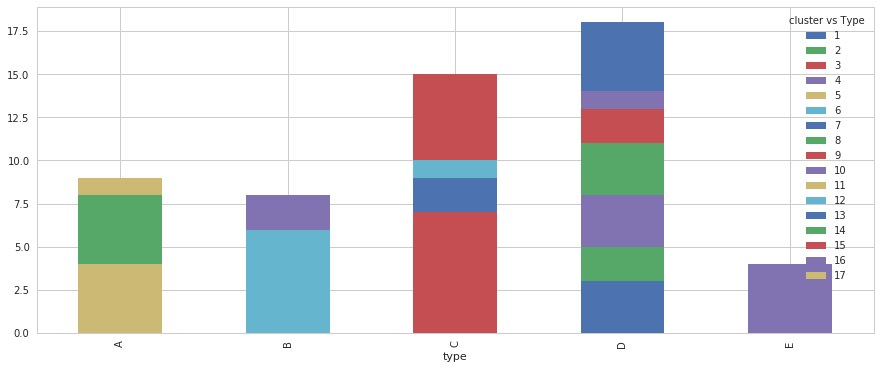

In [48]:
ct.plot.bar(figsize = (15, 6), stacked=True)
plt.legend(title='cluster vs Type')
plt.show()

Finally, we compute the chi-square test statistic and the associated p-value. The null hypothesis is the independence between the variables. SciPy implements this test in scipy.stats.chi2_contingency, which returns several objects. We're interested in the second result, which is the p-value.

In [49]:
st.chi2_contingency(ct)

(189.87500000000003,
 2.1050331838511189e-14,
 64,
 array([[ 0.5       ,  0.33333333,  1.16666667,  0.5       ,  0.16666667,
          1.        ,  0.33333333,  0.5       ,  0.33333333,  1.        ,
          0.5       ,  0.16666667,  0.66666667,  0.66666667,  0.83333333,
          0.16666667,  0.16666667],
        [ 0.44444444,  0.2962963 ,  1.03703704,  0.44444444,  0.14814815,
          0.88888889,  0.2962963 ,  0.44444444,  0.2962963 ,  0.88888889,
          0.44444444,  0.14814815,  0.59259259,  0.59259259,  0.74074074,
          0.14814815,  0.14814815],
        [ 0.83333333,  0.55555556,  1.94444444,  0.83333333,  0.27777778,
          1.66666667,  0.55555556,  0.83333333,  0.55555556,  1.66666667,
          0.83333333,  0.27777778,  1.11111111,  1.11111111,  1.38888889,
          0.27777778,  0.27777778],
        [ 1.        ,  0.66666667,  2.33333333,  1.        ,  0.33333333,
          2.        ,  0.66666667,  1.        ,  0.66666667,  2.        ,
          1.        ,  0.33

####  Interpretation of Result:

* The p-value is much lower than 0.05.
* There is strong evidence that the null hypothesis is False.
* We reject the null hypothesis and conclude that there is a statistically significant correlation between the Store Type and cluster of the stores.

#### <font color='navy'> Question 1A - Is there any statistically significant relation between City and Cluster of the stores ?
 
* Null Hypothesis H0        = City and Cluster are independent from each other.
* Alternative Hypothesis HA = City Tpe and cluster are not independent of each other. There is a relationship between them.

 
* City - categorical variable
* Cluster - categorical variable

Now, to determine if there is a statistically significant correlation between the variables, 
we use a chi-square test of independence of variables in a contingency table

Here, we create a contingency table, with the frequencies of all possible values

In [50]:
# Contingency table
ct2 = pd.crosstab(store['city'], store['cluster'])
ct2

cluster,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
city,,,,,,,,,,,,,,,,,
Ambato,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
Babahoyo,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Cayambe,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Cuenca,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Daule,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
El Carmen,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Esmeraldas,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Guaranda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Guayaquil,1,0,2,0,0,1,0,0,0,3,0,0,0,0,0,0,1


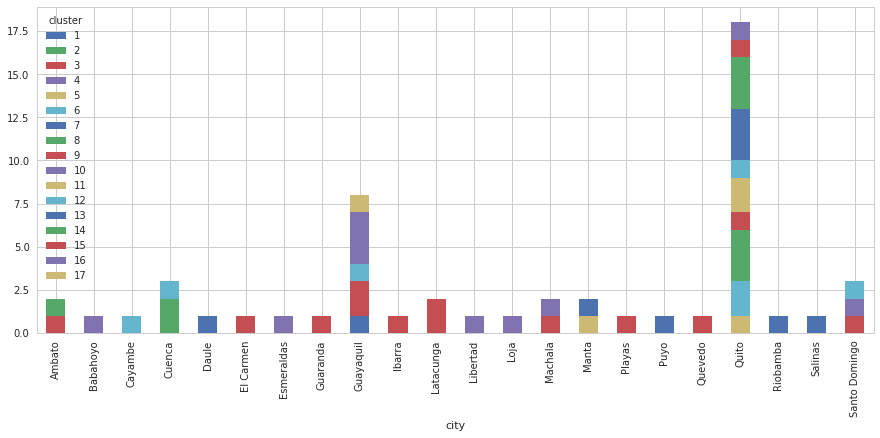

In [51]:
ct2.plot.bar(figsize = (15, 6), stacked=True)
plt.legend(title='cluster')
plt.show()

In [52]:
st.chi2_contingency(ct2)

(319.47857142857151,
 0.73311334184892685,
 336,
 array([[ 0.11111111,  0.07407407,  0.25925926,  0.11111111,  0.03703704,
          0.22222222,  0.07407407,  0.11111111,  0.07407407,  0.22222222,
          0.11111111,  0.03703704,  0.14814815,  0.14814815,  0.18518519,
          0.03703704,  0.03703704],
        [ 0.05555556,  0.03703704,  0.12962963,  0.05555556,  0.01851852,
          0.11111111,  0.03703704,  0.05555556,  0.03703704,  0.11111111,
          0.05555556,  0.01851852,  0.07407407,  0.07407407,  0.09259259,
          0.01851852,  0.01851852],
        [ 0.05555556,  0.03703704,  0.12962963,  0.05555556,  0.01851852,
          0.11111111,  0.03703704,  0.05555556,  0.03703704,  0.11111111,
          0.05555556,  0.01851852,  0.07407407,  0.07407407,  0.09259259,
          0.01851852,  0.01851852],
        [ 0.16666667,  0.11111111,  0.38888889,  0.16666667,  0.05555556,
          0.33333333,  0.11111111,  0.16666667,  0.11111111,  0.33333333,
          0.16666667,  0.0555

####  Interpretation of Result:

* The p-value is higher than 0.05.
* There is NO evidence to reject Null Hypothesis.
* We can continue with the null hypothesis and conclude that there is no dependence of cluster and cities

### <font color='salmon'> t-Test

#### <font color='navy'> Question 2 - Is there any statistically significant relation between Store Type and Sales of the stores ?

* Null Hypothesis H0        = Promotion and Sales are independent from each other.
* Alternative Hypothesis HA = Promotion and Sales are not independent of each other. There is a relationship between them.


* Promotion - categorical variable - Independent variable
* Sales - continuous variable - Dependent variable

Now, to determine if there is a statistically significant correlation between the variables, 
we use a student t test

2-sample t-test: testing for difference across populations

In [53]:
promo_sales = train[train['onpromotion'] == 1.0]['unit_sales']
nopromo_sales = train[train['onpromotion'] == 0.0]['unit_sales']
st.ttest_ind(promo_sales, nopromo_sales, equal_var = False)

Ttest_indResult(statistic=46.625049886627622, pvalue=0.0)

### <font color='salmon'> Correlation / Regression

#### <font color='navy'> Question 3 - Is there any statistically significant relation between  Oil price and Sales of the stores ?

* Null Hypothesis H0        = Oil price and Sales are independent from each other.
* Alternative Hypothesis HA = Oil price and Sales are not independent of each other. There is a relationship between them.


* Oil Price - Independent continuous variable
* Sales - Dependent continuous variable

##### We will do Simple Linear Regression now

In [54]:
lm0 = smf.ols(formula = 'unit_sales ~ dcoilwtico', data = train).fit()

In [55]:
#print the Result 
print(lm0.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_sales   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6234
Date:                Fri, 01 Dec 2017   Prob (F-statistic):              0.430
Time:                        01:47:18   Log-Likelihood:            -7.6000e+06
No. Observations:             1520384   AIC:                         1.520e+07
Df Residuals:                 1520382   BIC:                         1.520e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6801      0.066    132.129      0.0

No relation between oil price on sales

> ### <font color='salmon'>Random Forest - Trying to predict Sales

In [56]:
X_train = train.drop(['unit_sales', 'description', 'locale_name','locale','city','state','family','type_x','type_y','cluster','class','perishable','transferred', 'dcoilwtico'], axis = 1)
y_train = train.unit_sales

In [57]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 15)
y = rf.fit(X_train, y_train)
print('model fit')

model fit


In [58]:
X_test = test
y_test = rf.predict(X_test)

In [59]:
result = pd.DataFrame({'id':test.id, 'unit_sales': y_test}).set_index('id')
result = result.sort_index()
result[result.unit_sales < 0] = 0
result.to_csv('submissionR.csv', index=False)
print('submission created')


submission created


### <font color='salmon'> XGBOOST - Try to predict Sales

In [60]:
train_items1 = train_items1.drop(['unit_sales','family','class','perishable'], axis = 1)

In [61]:
train_items1.head()

,id,store_nbr,item_nbr,onpromotion,day_item_purchased,month_item_purchased,quarter_item_purchased,year_item_purchased
0,14269441,40,502224,-1,20,11,4,2013
1,23183502,45,502224,0,1,5,2,2014
2,83555679,48,502224,0,29,6,2,2016
3,33349722,5,502224,1,19,10,4,2014
4,21430616,35,502224,-1,28,3,1,2014


In [62]:
train_items2 = train_items2.drop(['id','store_nbr','item_nbr','onpromotion', 'day_item_purchased','month_item_purchased','quarter_item_purchased','year_item_purchased','family','class','perishable'], axis = 1)

In [63]:
train_items2.head()

,unit_sales
0,0.693147
1,1.945910
2,0.693147
3,1.098612
4,0.693147


In [64]:
Xg_train, Xg_valid = train_test_split(train_items1, test_size=0.012, random_state=10)
Yg_train, Yg_valid = train_test_split(train_items2, test_size=0.012, random_state=10)
features = list(train_items1.columns.values)
features2 = list(train_items2.columns.values)

In [65]:
features 

['id',
 'store_nbr',
 'item_nbr',
 'onpromotion',
 'day_item_purchased',
 'month_item_purchased',
 'quarter_item_purchased',
 'year_item_purchased']

In [66]:
features2

['unit_sales']

In [67]:
#dtrain = xgb.DMatrix(Xg_train[features], Xg_train.unit_sales)
#dvalid = xgb.DMatrix(Xg_valid[features], Xg_valid.unit_sales)
#Xg_train.dtypes

In [68]:
dtrain = xgb.DMatrix(Xg_train[features], Yg_train[features2])
dvalid = xgb.DMatrix(Xg_valid[features], Yg_valid[features2])

In [69]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

In [70]:
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [71]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 30
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]


In [72]:
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)


[0]	train-rmse:1.23623	eval-rmse:1.24275	train-rmspe:0.705863	eval-rmspe:0.694109
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 20 rounds.
[1]	train-rmse:1.06076	eval-rmse:1.06654	train-rmspe:0.832302	eval-rmspe:0.798066
[2]	train-rmse:0.946486	eval-rmse:0.951124	train-rmspe:1.02213	eval-rmspe:0.971588
[3]	train-rmse:0.89234	eval-rmse:0.896266	train-rmspe:1.24622	eval-rmspe:1.17776
[4]	train-rmse:0.855402	eval-rmse:0.858694	train-rmspe:1.42012	eval-rmspe:1.34425
[5]	train-rmse:0.840648	eval-rmse:0.843594	train-rmspe:1.57337	eval-rmspe:1.48594
[6]	train-rmse:0.833106	eval-rmse:0.835794	train-rmspe:1.67634	eval-rmspe:1.58568
[7]	train-rmse:0.829094	eval-rmse:0.831656	train-rmspe:1.76477	eval-rmspe:1.66728
[8]	train-rmse:0.822038	eval-rmse:0.824306	train-rmspe:1.81988	eval-rmspe:1.72826
[9]	train-rmse:0.818297	eval-rmse:0.820513	train-rmspe:1.86756	eval-rmspe:1.77796
[10]	train-rmse:0.815862	eval-rmse:

In [73]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(Xg_valid[features]))
error = rmspe(Yg_valid.unit_sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

Validating
RMSPE: 3.346221


In [74]:
testg.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [75]:
testg['date'] = pd.to_datetime(testg['date'], format='%Y-%m-%d')
testg['day_item_purchased'] = testg['date'].dt.day
testg['month_item_purchased'] =testg['date'].dt.month
testg['quarter_item_purchased'] = testg['date'].dt.quarter
testg['year_item_purchased'] = testg['date'].dt.year
testg.drop('date', axis=1, inplace=True)

In [76]:
testg.head()

,id,store_nbr,item_nbr,onpromotion,day_item_purchased,month_item_purchased,quarter_item_purchased,year_item_purchased
0,125497040,1,96995,False,16,8,3,2017
1,125497041,1,99197,False,16,8,3,2017
2,125497042,1,103501,False,16,8,3,2017
3,125497043,1,103520,False,16,8,3,2017
4,125497044,1,103665,False,16,8,3,2017


In [77]:
features

['id',
 'store_nbr',
 'item_nbr',
 'onpromotion',
 'day_item_purchased',
 'month_item_purchased',
 'quarter_item_purchased',
 'year_item_purchased']

In [78]:
testg.loc[(train_items.unit_sales<0),'unit_sales'] = 1 
#testg['unit_sales'] =  train_items['unit_sales'].apply(pd.np.log1p) 
testg['onpromotion'] = testg['onpromotion'].astype('category')
cat_columns = testg.select_dtypes(['category']).columns
testg[cat_columns] = testg[cat_columns].apply(lambda x: x.cat.codes)

In [79]:
dtest = xgb.DMatrix(testg[features])

In [80]:
test_probs = gbm.predict(dtest)
print("Make predictions on the test set")

Make predictions on the test set


In [81]:
result = pd.DataFrame({"id": test["id"], 'unit_sales': np.expm1(test_probs)})
result.to_csv("submissionX2.csv", index=False)
print("Submission created")

Submission created
